In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "./../"
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## 3.1 MNIST


- MNIST は高校生やアメリカ国勢調査局の職員が手書きした70,000個の数字画像のデータセット


- 機械学習における Hello World らしい...

In [2]:
# テキストに載っているコード
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

HTTPError: HTTP Error 404: Dataset 'mnist-original' not found on mldata.org.

テキストに載っている方法は mldata.org が落ちていて使えないので、他のところからダウンロードしましょう

In [3]:
import io
from urllib.request import urlopen
from scipy.io.arff import loadarff
def fetch_mnist():
    content = urlopen(
        'https://www.openml.org/data/download/52667/mnist_784.arff').read()
    data, meta = loadarff(io.StringIO(content.decode('utf8')))
    data = data.view([('pixels', '<f8', 784), ('class', '|S1')])
    return data['pixels'], data['class']

X, y = fetch_mnist()
y = np.ascontiguousarray(y, dtype=np.float32)
print("X.shape = ",X.shape)
print("y.shape = ",y.shape)

X.shape =  (70000, 784)
y.shape =  (70000,)


Saving figure some_digit_plot


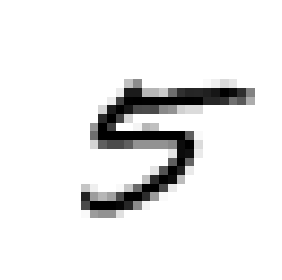

y[36000] =  5.0


In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[41000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")

save_fig("some_digit_plot")
plt.show()
print("y[36000] = ",y[41000])

- MNISTでは最初の60000個を訓練データ, 後の10000個をテストデータとして用いる。
- cross validation において特定の数字が入ってない訓練データを使うのを防ぐために, 訓練データをシャッフルしておきたい

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 3.2 二項分類器の訓練 (Binary classifier)


- 5 であるかどうかを判定する分類器をつくる


- sklearn の SGDClassifier (Stochastic Gradient Descent) を用いる

In [6]:
from sklearn.linear_model import SGDClassifier

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

[ True]


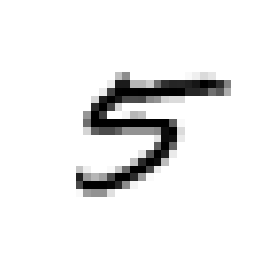

In [7]:
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")

print(sgd_clf.predict([some_digit]))

## 3.3 性能指標
### 3.3.1 cross-validationを用いた正解率の測定

- sklearn の cross_val_score で何を行っているかを見る.
- <font color="Green">StratifiedKFold</font> を用いて, 各クラスの比率に合わせた fold をつくる(層化抽出). ここでは3-fold
- 各 validation の fold において正解数がどれくらいの割合になっているかを出力する.


In [8]:
from sklearn.model_selection import cross_val_score
print("scores by cross_val_score")
print(cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy"))

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

print("\n")
print("scores by StratifiedKFold")
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

scores by cross_val_score
[0.9605  0.95595 0.95375]


scores by StratifiedKFold
0.9605
0.95595
0.95375


- 95%は高そうに見えるが, 試しにbaselineとして, どんな入力に対しても5ではない, と返す分類器の性能をcross-validationで測ると90%も正解率が出る。


- 歪んだデータセットだと, 正解率での評価は難しい


In [9]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90745, 0.9125 ])

### 3.3.2 混同行列での性能評価を考える


- prediction のうち, 偽陽性や偽陰性の数を含めた array を返してくれる.


- さっきの SGDClassifier だと989件の偽陰性, 1607件の偽陽性 が見られた



![title](png/confusion-matrix.png)

In [10]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[52972,  1607],
       [  989,  4432]], dtype=int64)

- 陽性と予想されたもののうち, 正解率がどれくらいか → precision (適合率)


- 本来の陽性のうち, どれくらいが陽性とちゃんと分類されたか → recall (再現率)


$$
{\rm precision} = \frac{TP}{TP+FP},\\
\\
\\
{\rm recall} = \frac{TP}{TP+FN}
$$

In [11]:
from sklearn.metrics import precision_score, recall_score

print("precision_score = ",precision_score(y_train_5, y_train_pred))
print("recall_score = ",recall_score(y_train_5, y_train_pred))

precision_score =  0.7338963404537175
recall_score =  0.8175613355469471


- precision と recall の調和平均を取る F値 という指標もある
$$
F_1 = \frac{2}{\frac{1}{\rm precision}+\frac{1}{\rm recall}}
$$

- $F_1$ を上げることが常に良いわけではない。


- precision と recall はトレードオフの関係にあるので, 状況に応じて評価関数を使い分けると良い (3.3.4 参照).


- SGDClassifier には <font color="Green">method="decision_function"</font> があり, 入力に対するある種のスコアを出力してくれる.

![title](png/decision-threshold.png)

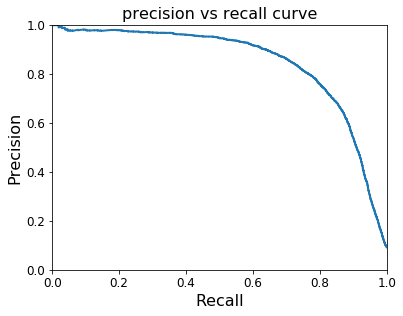

In [12]:
from sklearn.metrics import precision_recall_curve

# decision function: threshold を返してくれる
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(6, 4.5))
plot_precision_vs_recall(precisions, recalls)
#save_fig("precision_vs_recall_plot")
plt.title("precision vs recall curve",fontsize=16)
plt.show()

- 偽陽性率 (FPR) に対する真陽性率 (TPR or recall) をプロットした ROC 曲線もよく使われる

FP: 実際陰性のもののうち、偽陽性とカウントされているものの割合
$$
FPR = \frac{FP}{FP+TN}
$$

- FPR と TPR もトレードオフ関係になっている.


- 性能評価として曲線の下の面積, AUC (area under the curve) が使われる.

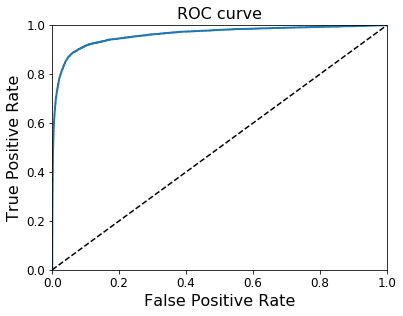

ROC AUC score =  0.9614189997126432


In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(6, 4.5))
plot_roc_curve(fpr, tpr)
#save_fig("roc_curve_plot")
plt.title("ROC curve",fontsize=16)
plt.show()

print("ROC AUC score = ",roc_auc_score(y_train_5, y_scores))

- AUC を用いて, RandomForestClassifier と SGDClassifier の性能比較をする.


- <font color="Green">method="predict_proba"</font>  を使って陽性と判断される確率を出力させる.

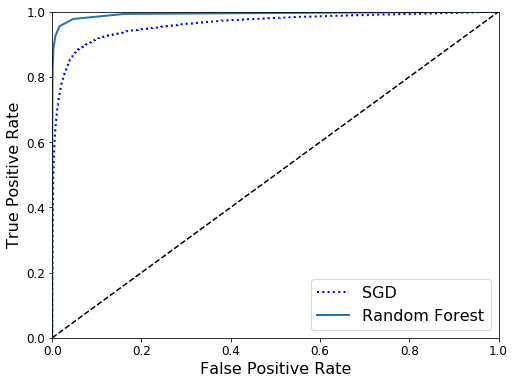

ROC AUC score (RandomForest) =  0.9928250745111685


In [14]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
#save_fig("roc_curve_comparison_plot")
plt.show()

print("ROC AUC score (RandomForest) = ",roc_auc_score(y_train_5, y_scores_forest))

## 3.4 多クラス分類 ( Multiclass classification )

- **OVA 法** (one-versus-all): 10個の2項分類器を使い, 最もスコアの高かったクラスが選ばれる


- **OVO 法** (one-versus-one): 総当たりさせて, 一番強かったクラスを選ぶ.


- sklearn では多クラス分類しようとすると自動的に OVA 法を実行してくれる(らしい)

OVO が使いたいときは 
```Python
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
```
とすればよい

In [15]:
sgd_clf.fit(X_train, y_train) # y_train_5 でないことに注意

some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-157432.98008725, -445227.82244001, -521088.52711264,
        -250757.97930095, -140979.84086904,  188696.88258675,
        -461652.71770618,  -64496.51283685, -249672.57545245,
        -558893.39371828]])

In [16]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.81908618, 0.86379319, 0.84492674])

85% 前後の成績が出ているが, <font color="Green">StandardScaler</font> を使って規格化するだけで成績はもっとよくなる

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91131774, 0.90884544, 0.90883633])

## 3.5 誤分類の分析

- モデルが犯す誤分類のタイプを分析することで, モデルの改良方法を探す.


- とりあえず confusion matrix (混同行列)をプロットする

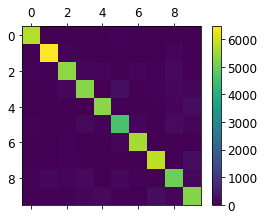

In [18]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
plt.matshow(conf_mx, cmap=plt.cm.viridis)
plt.colorbar(shrink = 0.8)
#save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

- 5 が周りに比べて低い → 5 のデータ点自体が少ない or/and 5 の分類の性能が悪い


- データセットの中のそれぞれのクラスの数で confusion_matrix の値を規格化してあげる.
- 対角成分は 0 とする

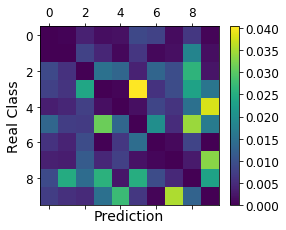

In [19]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.viridis)
plt.xlabel("Prediction")
plt.ylabel("Real Class")
plt.colorbar(shrink = 0.8)
#save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

- 8 と 9 は他の数字に間違えられやすい


- 3 と 5 は間違えられやすい
    - 以下は, 左が3と分類された数字, 右が5と分類された数字となっている
    - 今回の SGDClassifier による分類器は画像の回転や平行移動に弱いので, 数字が真ん中にくるような前処理を行うとよさそう...

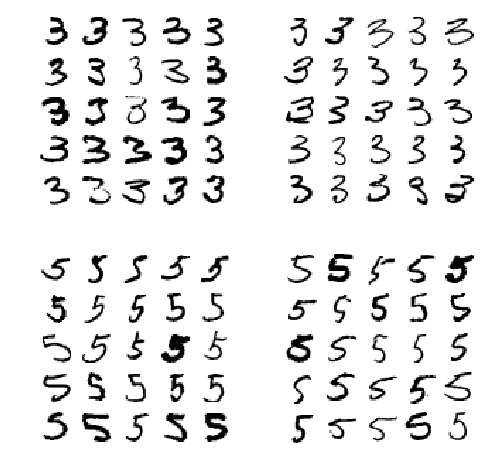

In [20]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
#save_fig("error_analysis_digits_plot")
plt.show()

## 3.6 多ラベル分類


- 複数人が映っている写真で, 誰が映っているかを知りたい場合など, 多クラス分類が必要になってくる状況がある


- 多ラベルの教師データを利用して, KNeghiborsClassifier などを使えばよい
- average = "weighted" とすればラベルによって重みづけを変えることもできる

```Python
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")
```

## 3.7 多出力分類

- ノイズ入りのMNIST画像からクリーンな数字の画像を出力するシステム (各ピクセルを0~255の値に分類する(もはや回帰に近い)) etc.


In [21]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [24]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

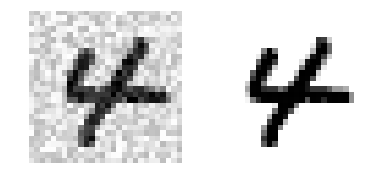

In [25]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
#save_fig("noisy_digit_example_plot")
plt.show()

In [27]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

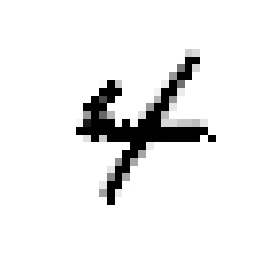

In [28]:
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
#save_fig("cleaned_digit_example_plot")